## Kuramoto-Sivashinsky: Two-step Method

In [1]:
import sys
#sys.path.append('/Users/josorior/Documents/UW/research/keql/KEQL/source')
#sys.path.append('/Users/yasaminjalalian/Repos/KEQL/source')
sys.path.append('/home/juanfelipe/Desktop/research/keql/source')

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import * 
from models import *
from data_loader import * 
import pysindy as ps
from scipy.io import loadmat

import matplotlib.tri as tri
import matplotlib.pyplot as plt

from jax.config import config; 
config.update("jax_enable_x64", True)

In [3]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [4]:
#model = 'pendulum'

In [5]:
# 2-step dictionary
keys = ['optim_sgm_u','optim_nugget_u','rkhs_u','optim_sgm_P','optim_nugget_P','nugget_P', 'rkhs_P','f_pred_test']
two_step_dict = dict.fromkeys(keys)

### Solution: Two-Step Method

In [6]:
data = loadmat('/home/juanfelipe/Desktop/research/keql/examples/KS/data/kuramoto_sivishinky.mat')

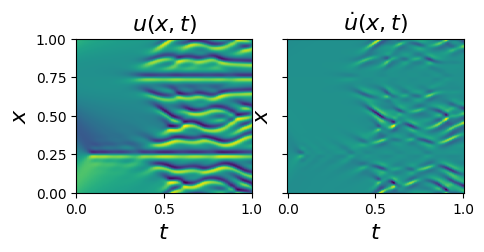

In [7]:
# t scaler
t_scaler = MinMaxScaler()
t = data['tt'].T
t = np.ravel(t_scaler.fit_transform(t))
dt = t[1] - t[0]
# x scaler
x_scaler = MinMaxScaler()
x = data['x']
x = np.ravel(x_scaler.fit_transform(x))
dx = x[1] - x[0]
# u scaler
u_scaler = MinMaxScaler()
u = data['uu'].reshape(-1,1)
u = u_scaler.fit_transform(u)
u = u.reshape(1024, 251)

# Plot u and u_dot
plt.figure(figsize = (5, 2))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u)
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$x$', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)

u_t = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
u_x = ps.FiniteDifference(axis=0)._differentiate(u, t=dx)
u_xx = ps.FiniteDifference(axis=0,d=2)._differentiate(u, t=dx)
u_xxxx = ps.FiniteDifference(axis=0,d=4)._differentiate(u, t=dx)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_t)
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$x$', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()
#u = u.reshape(len(x), len(t), 1)

### Experiment

Let's code the function $f(x,y) = \sin(x)\sin(y)$ and see how good the interpolant is. 

In [27]:
def f(x,y): 
    return np.sin(x)*np.sin(y)
def f_x(x,y):
    return np.cos(x)*np.sin(y)
def f_y(x,y):
    return np.sin(x)*np.cos(y)

In [28]:
N = 2000
xlist = np.random.uniform(low=0, high = 1, size = N)
ylist = np.random.uniform(low=0, high = 1, size = N)
X = np.vstack((xlist, ylist)).T
u_train = f(X[:,0],X[:,1])
u_x_train = f_x(X[:,0],X[:,1])
u_y_train = f_y(X[:,0],X[:,1])
#plt.tricontourf(X[:,0],X[:,1],u_train)

In [29]:
e = len(u_train)
optim_rho_u, alphas, optim_nugget_u = kernel_parameters_Matern52_2D(X, u_train.reshape(-1,1), e)

In [30]:
u_pred_train, u_x_pred_train, u_y_pred_train , u_xx_pred_train , u_xxxx_pred_train = predictions_KS(X, X, Matern_Kernel_52_2D, optim_rho_u, alphas, e , e)

Text(0.5, 1.0, 'u_true_train')

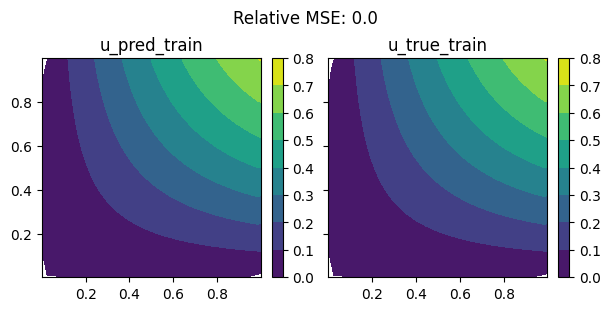

In [31]:
# Interpolant at training points
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2 ,sharey= True, figsize = (6,3),constrained_layout=True)
n_mse = mean_squared_error(u_pred_train, u_train)/mean_squared_error(u_pred_train*0, u_train)
fig.suptitle('Relative MSE: {}'.format(round(n_mse,16)))
ax1plot = ax1.tricontourf(X[:,0],X[:,1], u_pred_train.flatten())
plt.colorbar(ax1plot, ax = ax1)
ax1.set_title('u_pred_train')
ax2plot =ax2.tricontourf(X[:,0],X[:,1], u_train.flatten())
plt.colorbar(ax2plot, ax = ax2)
ax2.set_title('u_true_train')

Text(0.5, 1.0, 'u_x_train')

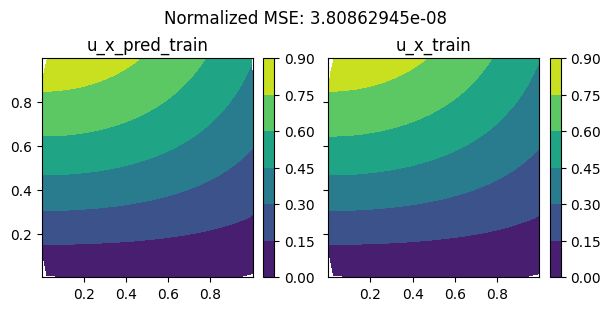

In [32]:
# First t derivative at training points
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2 ,sharey= True, figsize = (6,3),constrained_layout=True)
n_mse = mean_squared_error(u_x_pred_train, u_x_train)/mean_squared_error(u_x_pred_train*0, u_x_train)
fig.suptitle('Normalized MSE: {}'.format(round(n_mse,16)))
ax1plot = ax1.tricontourf(X[:,0],X[:,1], u_x_pred_train.flatten())
plt.colorbar(ax1plot, ax=ax1)
ax1.set_title('u_x_pred_train')
ax2plot = ax2.tricontourf(X[:,0],X[:,1], u_x_train.flatten())
plt.colorbar(ax2plot, ax=ax2)
ax2.set_title('u_x_train')

### > Step 1: Learning $u's$

In [8]:
T, X = np.meshgrid(t,x)
# N x 2 of all collocation points 
all_pairs = np.vstack([T.ravel(), X.ravel()]) 
# N values of u at all collocation points 
u_all_flat = u.flatten() 
# N values of u_t at all collocation points
u_t_all_flat = u_t.flatten()
# N values of u_x at all collocation points
u_x_all_flat = u_x.flatten()
# N values of u_xx at all collocation points
u_xx_all_flat = u_xx.flatten()
# N values of u_xxxx at all collocation points
u_xxxx_all_flat = u_xxxx.flatten()

# Stack all triples
u_all_ = np.vstack([all_pairs,u_all_flat]).T # N x 3 of collocation pts and u values 
u_t_all_ = np.vstack([all_pairs,u_t_all_flat]).T # N x 3 of collocation pts and u_t values
u_x_all_ = np.vstack([all_pairs,u_x_all_flat]).T # N x 3 of collocation pts and u_x values
u_xx_all_ = np.vstack([all_pairs,u_xx_all_flat]).T # N x 3 of collocation pts and u_xx values
u_xxxx_all_ = np.vstack([all_pairs,u_xxxx_all_flat]).T # N x 3 of collocation pts and u_xxxx values

# Get random indices
idx_train = np.random.randint(len(u_all_), size = 2000)
idx_test = np.random.randint(len(u_all_), size = int(1e3))


## Get training and testing points from triples

# u
u_train_ = u_all_[idx_train,:]
u_test_ = u_all_[idx_test,:]
t_train, x_train, u_train = u_train_[:,0], u_train_[:,1], u_train_[:,2]
t_test, x_test, u_test = u_test_[:,0], u_test_[:,1], u_test_[:,2]
# u_t
u_t_train_ = u_t_all_[idx_train,:]
u_t_test_ = u_t_all_[idx_test,:]
t_train, x_train, u_t_train = u_t_train_[:,0], u_t_train_[:,1], u_t_train_[:,2]
t_test, x_test, u_t_test = u_t_test_[:,0], u_t_test_[:,1], u_t_test_[:,2]
# u_x
u_x_train_ = u_x_all_[idx_train,:]
u_x_test_ = u_x_all_[idx_test,:]
t_train, x_train, u_x_train = u_x_train_[:,0], u_x_train_[:,1], u_x_train_[:,2]
t_test, x_test, u_x_test = u_x_test_[:,0], u_x_test_[:,1], u_x_test_[:,2]
# u_xx
u_xx_train_ = u_xx_all_[idx_train,:]
u_xx_test_ = u_xx_all_[idx_test,:]
t_train, x_train, u_xx_train = u_xx_train_[:,0], u_xx_train_[:,1], u_xx_train_[:,2]
t_test, x_test, u_xx_test = u_xx_test_[:,0], u_xx_test_[:,1], u_xx_test_[:,2]
# u_xxxx
u_xxxx_train_ = u_xxxx_all_[idx_train,:]
u_xxxx_test_ = u_xxxx_all_[idx_test,:]
t_train, x_train, u_xxxx_train = u_xxxx_train_[:,0], u_xxxx_train_[:,1], u_xxxx_train_[:,2]
t_test, x_test, u_xxxx_test = u_xxxx_test_[:,0], u_xxxx_test_[:,1], u_xxxx_test_[:,2]


e, e_test = len(u_train), len(u_test)
X_train = np.vstack([t_train, x_train]).T
X_test = np.vstack([t_test, x_test]).T

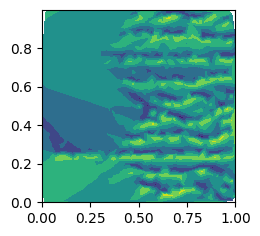

In [9]:
plt.figure(figsize = (2.5, 2.5))
#plt.scatter(x_train, t_train, c = u_train)
plt.tricontourf(t_train, x_train, u_train)

In [10]:
optim_rho_u, alphas, optim_nugget_u = kernel_parameters_Matern112_2D(X_train, u_train.reshape(-1,1), e)

In [11]:
# Save true values to be used in one-step
two_step_dict['optim_rho_u'] = optim_rho_u 
two_step_dict['optim_nugget_u'] = optim_nugget_u
optim_rho_u, optim_nugget_u

(array([0.09018729]), array([1.e-08]))

In [12]:
u_pred_train, u_t_pred_train, u_x_pred_train , u_xx_pred_train , u_xxxx_pred_train = predictions_KS(X_train, X_train, Matern_Kernel_112_2D, optim_rho_u, alphas, e , e)
u_pred_test, u_t_pred_test, u_x_pred_test , u_xx_pred_test , u_xxxx_pred_test  = predictions_KS(X_test,  X_train, Matern_Kernel_112_2D, optim_rho_u, alphas, e, e_test)

In [13]:
# # Save true values to warm up the onepfive method
# np.save('data/u_pred_train.npy', u_pred_train)
# np.save('data/u_pred_test.npy', u_pred_test)
# # Save true gradients for comparing later
# np.save('data/u_x_train.npy',u_x_train)
# np.save('data/u_xx_train.npy',u_xx_train)
# # Save gradients for one step method
# np.save('data/u_x_pred_train.npy',u_x_pred_train)
# np.save('data/u_xx_pred_train.npy',u_xx_pred_train)
# np.save('data/u_x_pred_test.npy',u_x_pred_test)
# np.save('data/u_xx_pred_test.npy',u_xx_pred_test)

Text(0.5, 1.0, 'u_true_train')

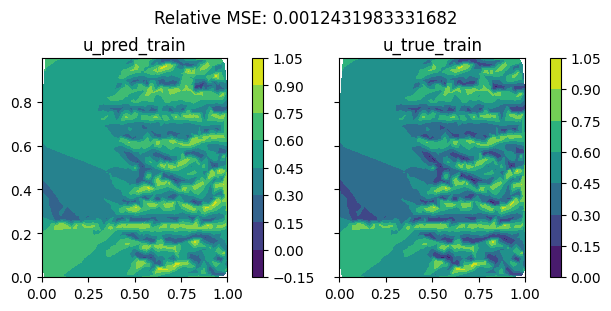

In [13]:
# u at training points
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2 ,sharey= True, figsize = (6,3),constrained_layout=True)
n_mse = mean_squared_error(u_pred_train, u_train)/mean_squared_error(u_pred_train*0, u_train)
fig.suptitle('Relative MSE: {}'.format(round(n_mse,16)))
ax1plot = ax1.tricontourf(t_train, x_train, u_pred_train.flatten())
plt.colorbar(ax1plot, ax = ax1)
ax1.set_title('u_pred_train')
ax2plot =ax2.tricontourf(t_train, x_train, u_train.flatten())
plt.colorbar(ax2plot, ax = ax2)
ax2.set_title('u_true_train')

Text(0.5, 1.0, 'u_true_test')

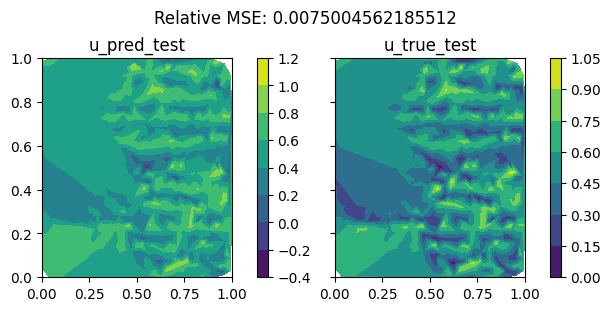

In [14]:
# u at testing points
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2 ,sharey= True, figsize = (6,3),constrained_layout=True)
n_mse = mean_squared_error(u_pred_test, u_test)/mean_squared_error(u_pred_test*0, u_test)
fig.suptitle('Relative MSE: {}'.format(round(n_mse,16)))
ax1plot = ax1.tricontourf(t_test, x_test, u_pred_test.flatten())
plt.colorbar(ax1plot, ax=ax1)
ax1.set_title('u_pred_test')
ax2plot =ax2.tricontourf(t_test, x_test, u_test.flatten())
plt.colorbar(ax2plot, ax=ax2)
ax2.set_title('u_true_test')

Text(0.5, 1.0, 'u_t_true_train')

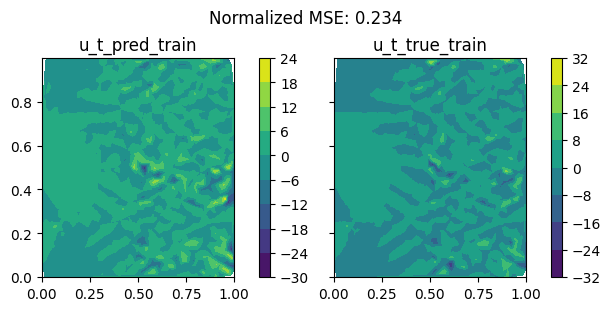

In [15]:
# u_t at training points
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2 ,sharey= True, figsize = (6,3),constrained_layout=True)
n_mse = mean_squared_error(u_t_pred_train, u_t_train)/mean_squared_error(u_t_pred_train*0, u_t_train)
fig.suptitle('Normalized MSE: {}'.format(round(n_mse,3)))
ax1plot = ax1.tricontourf(t_train, x_train, u_t_pred_train.flatten())
plt.colorbar(ax1plot, ax=ax1)
ax1.set_title('u_t_pred_train')
ax2plot = ax2.tricontourf(t_train, x_train, u_t_train.flatten())
plt.colorbar(ax2plot, ax=ax2)
ax2.set_title('u_t_true_train')

Text(0.5, 1.0, 'u_t_true_test')

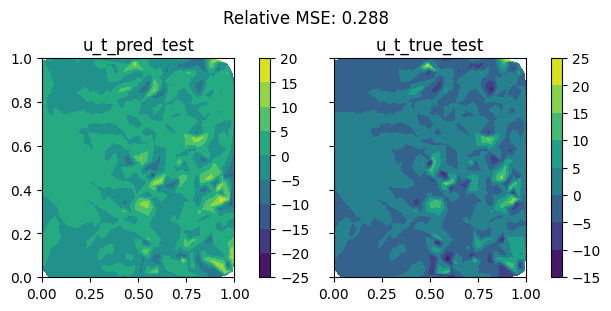

In [16]:
# u_t at testing points
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2 ,sharey= True, figsize = (6,3),constrained_layout=True)
n_mse = mean_squared_error(u_t_pred_test, u_t_test)/mean_squared_error(u_t_pred_test*0, u_t_test)
fig.suptitle('Relative MSE: {}'.format(round(n_mse,3)))
ax1plot = ax1.tricontourf(t_test, x_test, u_t_pred_test.flatten())
plt.colorbar(ax1plot, ax=ax1)
ax1.set_title('u_t_pred_test')
ax2plot = ax2.tricontourf(t_test, x_test, u_t_test.flatten())
plt.colorbar(ax2plot, ax=ax2)
ax2.set_title('u_t_true_test')

Text(0.5, 1.0, 'u_x_true_train')

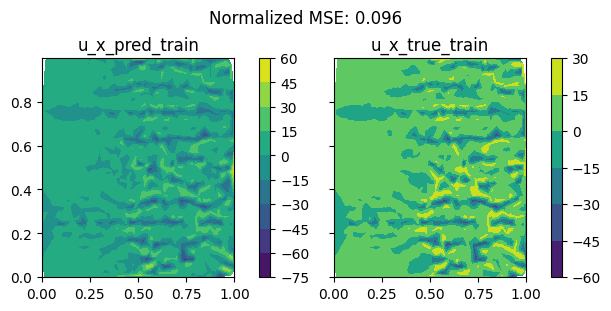

In [17]:
# u_x at training points
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2 ,sharey= True, figsize = (6,3),constrained_layout=True)
n_mse = mean_squared_error(u_x_pred_train, u_x_train)/mean_squared_error(u_x_pred_train*0, u_x_train)
fig.suptitle('Normalized MSE: {}'.format(round(n_mse,3)))
ax1plot = ax1.tricontourf(t_train, x_train, u_x_pred_train.flatten())
plt.colorbar(ax1plot, ax=ax1)
ax1.set_title('u_x_pred_train')
ax2plot = ax2.tricontourf(t_train, x_train, u_x_train.flatten())
plt.colorbar(ax2plot, ax=ax2)
ax2.set_title('u_x_true_train')

Text(0.5, 1.0, 'u_x_true_test')

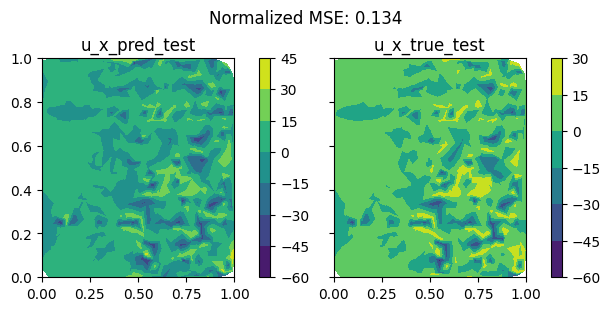

In [18]:
# u_x at testing points
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2 ,sharey= True, figsize = (6,3),constrained_layout=True)
n_mse = mean_squared_error(u_x_pred_test, u_x_test)/mean_squared_error(u_x_pred_test*0, u_x_test)
fig.suptitle('Normalized MSE: {}'.format(round(n_mse,3)))
ax1plot = ax1.tricontourf(t_test, x_test, u_x_pred_test.flatten())
plt.colorbar(ax1plot, ax=ax1)
ax1.set_title('u_x_pred_test')
ax2plot = ax2.tricontourf(t_test, x_test, u_x_test.flatten())
plt.colorbar(ax2plot, ax=ax2)
ax2.set_title('u_x_true_test')

RKHSs norms squared $u^*$

In [19]:
rkhs_u = []
G = K_2D(Matern_Kernel_112_2D, X_train, X_train, optim_rho_u)
# G = G + 1e-5*jnp.diag(jnp.diag(G)) # I had to regularize here (?)
alphas = np.linalg.solve(G[:,:,0], u_pred_train.flatten())
rkhs_u.append(np.dot(u_pred_train.flatten(),alphas))
# Print the norm
print('RKHS^2 norm of u^*: {}'.format(round(rkhs_u[0],2)))
# Save true values to be used in 1-step
two_step_dict['rkhs_u'] = rkhs_u

RKHS^2 norm of u^*: 8330.74


We compute the norm of $u_*$ since it is more regular than $u$.

> Step 2: Learning $P$

In [28]:
u_test.shape

(1000,)

In [29]:
s_train = np.hstack((X_train,u_train.T.reshape(-1,1),u_x_pred_train.T.reshape(-1,1),u_xx_pred_train.T.reshape(-1,1),u_xxxx_pred_train.T.reshape(-1,1))) # 30 * 5
s_test = np.hstack((X_test,u_test.T.reshape(-1,1),u_x_pred_test.T.reshape(-1,1),u_xx_pred_test.T.reshape(-1,1),u_xxxx_pred_test.T.reshape(-1,1))) # 30 * 5

#f_train = u_t_train.T.reshape(-1,1) This is not a fare comparison !

f_train = -u_train*u_x_pred_train.flatten() - u_xx_pred_train.flatten() + u_xxxx_pred_train.flatten() # we need the more accurate gradients, not the predicted ones right?

f_test = -u_test*u_x_pred_test.flatten() - u_xx_pred_test.flatten() + u_xxxx_pred_test.flatten() # we need the more accurate gradients, not the predicted ones right?


scaler_s_train = MinMaxScaler()
s_train_s = scaler_s_train.fit_transform(s_train)
s_test_s = scaler_s_train.transform(s_test)

In [30]:
optim_sgm_P, optim_nugget_P = grid_search_RBF(s_train_s,f_train)
#optim_d_P, optim_nugget_P = 2, 1e-16
# Save true values to be used in one-step
two_step_dict['optim_d_P'] = optim_sgm_P
two_step_dict['optim_nugget_P'] = optim_nugget_P

krr_optimal_P = KernelRidge(kernel='rbf', alpha = optim_nugget_P, gamma=1/(2*(optim_sgm_P**2))) 
#krr_optimal_P = KernelRidge(kernel='poly', alpha = optim_nugget_P, degree = optim_d_P) 
krr_optimal_P.fit(s_train_s, f_train) 
f_pred_train = krr_optimal_P.predict(s_train_s) 
f_pred_test = krr_optimal_P.predict(s_test_s)

In [34]:
print('Optimal sigma of P^*:{}  Nugget of P^*: {:.2e}'.format(optim_sgm_P,optim_nugget_P))
#print('Degree for kernel of P^*:{}  Nugget of P^*: {:.2e}'.format(optim_d_P,optim_nugget_P))

Optimal sigma of P^*:1.2795344310448808  Nugget of P^*: 1.00e-14


Text(0.5, 1.0, 'f_true_train')

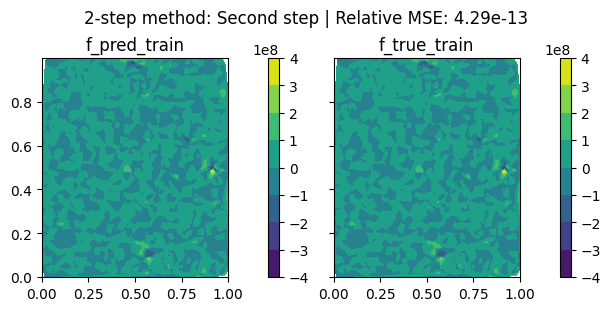

In [35]:
# Interpolant P^* at training points : P^*(hat S) vs. P(hat S)
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2 ,sharey= True, figsize = (6,3),constrained_layout=True)
n_mse = mean_squared_error(f_pred_train, f_train)/mean_squared_error(f_pred_train*0, f_train)
# u_t_train2 should be the estimation at the predicted input using the training collocation points and use the algebraic relation between the estimated gradients. 
fig.suptitle('2-step method: Second step | Relative MSE: {}'.format(round(n_mse,15)))
ax1plot = ax1.tricontourf(t_train, x_train, f_pred_train)
plt.colorbar(ax1plot, ax=ax1)
ax1.set_title('f_pred_train')
ax2plot = ax2.tricontourf(t_train, x_train, f_train)
plt.colorbar(ax2plot, ax=ax2)
ax2.set_title('f_true_train')

Text(0.5, 1.0, 'f_true_test')

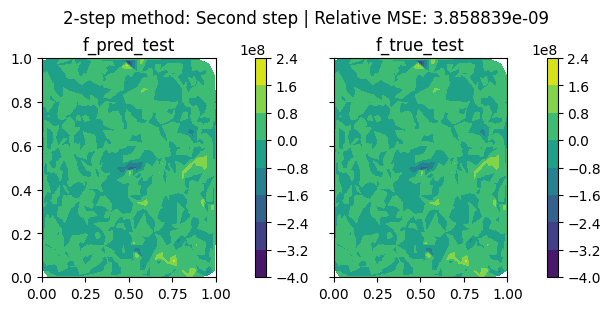

In [36]:
# Interpolant P^* at testing points
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2 ,sharey= True, figsize = (6,3),constrained_layout=True)
n_mse = mean_squared_error(f_pred_test, f_test)/mean_squared_error(f_pred_test*0, f_test)
fig.suptitle('2-step method: Second step | Relative MSE: {}'.format(round(n_mse,15)))
ax1plot = ax1.tricontourf(t_test, x_test, f_pred_test)
plt.colorbar(ax1plot, ax=ax1)
ax1.set_title('f_pred_test')
ax2plot = ax2.tricontourf(t_test, x_test, f_test)
plt.colorbar(ax1plot, ax=ax2)
ax2.set_title('f_true_test')

RKHS norm squared of $P^*$

In [37]:
# rkhs_P
nugget_P = 1e-7
G = K(Gaussian,s_train_s,s_train_s, optim_sgm_P) + nugget_P*np.eye(x_train.size) # added nugget here !
alphas_P = np.linalg.solve(G, f_pred_train)
rkhs_P = np.dot(f_pred_train,alphas_P)
print('RKHS^s norm of P^*: {}'.format(round(rkhs_P,2)))
# Save true values to be used in one-step
two_step_dict['rkhs_P'] = rkhs_P
two_step_dict['nugget_P'] = nugget_P

RKHS^s norm of P^*: 7.314319347976274e+18


In [28]:
# rkhs_P
nugget_P = 1e-7
G_test = K(Gaussian,s_test_s,s_test_s, optim_sgm_P) + nugget_P*np.eye(x_test.size) # added nugget here !
alphas_P_test = np.linalg.solve(G_test, f_pred_test)
rkhs_P_test = np.dot(f_pred_test,alphas_P_test)
print('RKHS^s norm of P^*: {}'.format(round(rkhs_P_test,2)))

RKHS^s norm of P^*: 6.350627286638294e+17


In [29]:
two_step_dict['f_pred_test'] = f_pred_test

Test

> Compute std of feature 1 $\sigma_{\text{s[:,1]}}$ of `s_train` and perturb feature 1 of `s_train` using $m \sigma_{\text{s[:,1]}}$ each element. $m \in (0.01,0.25)$.

100%|██████████| 5/5 [26:15<00:00, 315.10s/it]

[[0.30727993 0.3050641  0.2885457  0.51013681 0.79423204 0.41325149
  1.         0.39036376 0.98746251 0.40710987 1.         0.59360873
  0.94266459]
 [0.30727993 0.33722375 0.35063813 0.32375788 0.93078591 0.39707048
  0.39323253 0.32091598 0.97720464 1.         1.         1.
  0.42367987]
 [0.30727993 0.2961042  0.28178207 0.3193984  0.39498787 0.94373808
  0.34195873 0.35719948 0.45963877 0.98650573 0.48604069 1.
  1.        ]
 [0.30727993 0.30677019 0.42758127 0.26635028 0.27646377 0.78506115
  0.20752729 0.30331942 0.94757542 0.95296983 1.         1.
  0.99823277]
 [0.30727993 0.30538129 0.2889236  0.49172536 0.34692223 0.41988716
  0.99160895 0.86969185 0.60998713 0.36611525 0.58579217 0.95386336
  0.37916941]]


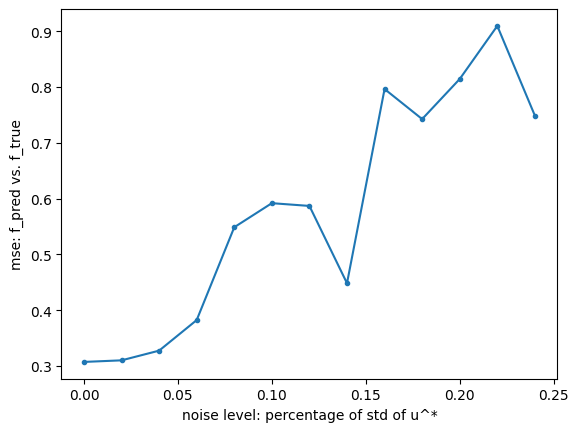

In [21]:
mses_P_all = []
for j in tqdm(range(5)):
    # Compute std per feature of s_train_s
    stds = np.std(s_train, axis = 0)
    beta = np.arange(0.0,0.25,0.02)
    scales = np.outer(beta, stds) 
    mses_P = []
    for i in tqdm(range(len(scales))):
        # Scales for current iteration
        scale = scales[i,:]
        # Copy s_train
        s_test = np.copy(s_train)
        # Perturb feature that contains u^* - Do this 10 times and average !!!
        s_test[:,1] = np.random.normal(s_train[:,1] , scale = scale[1])
        # Apply step one to perturbed u's 
        optim_sgm, alphas, optim_lmbd = kernel_parameters(x_train.reshape(-1,1), s_test[:,1].reshape(3,3).T, e)
        _, u_x_pred, u_xx_pred = predictions_ode(x_train, x_train, Gaussian, optim_sgm, alphas, e , e)
        s_test[:,2] = u_x_pred.T.reshape(-1,1).flatten()
        s_test[:,3] = u_xx_pred.T.reshape(-1,1).flatten()
        # Scale the new s_test
        s_test_s = scaler_s_train.transform(s_test)
        # Compute predictions on test
        f_pred_test = krr_optimal_P.predict(s_test_s)
        # True test -> Why if I use this rule for s_test_s the bellow rule cannot be compared with f_pred_test
        f_true_test = f_true_Test(model, s_test)
        # Compute mse per scale 
        mses_P.append(mean_squared_error(f_true_test,f_pred_test)/mean_squared_error(0*f_true_test,f_true_test))
# Plot - We have a vector of dimension 4 of scales vs. mses
    mses_P_all.append(mses_P)
mses_P_all = np.array(mses_P_all)
print(mses_P_all)
mean_mses_P_all = np.mean(mses_P_all, axis = 0)
plt.plot(beta,mean_mses_P_all,'.-')
plt.xlabel('noise level: percentage of std of u^*')
plt.ylabel('mse: f_pred vs. f_true')
plt.show()

In [23]:
np.save('data/two_step_dict.npy',two_step_dict)